In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
from pathlib import Path
from sklearn import metrics

In [4]:
# Sets the video card to be used
torch.cuda.set_device(0)

In [5]:
PATH = Path("data/dog_and_cats_breeds")
list(PATH.iterdir())

[PosixPath('data/dog_and_cats_breeds/.ipynb_checkpoints'),
 PosixPath('data/dog_and_cats_breeds/train.csv'),
 PosixPath('data/dog_and_cats_breeds/test'),
 PosixPath('data/dog_and_cats_breeds/tmp'),
 PosixPath('data/dog_and_cats_breeds/train'),
 PosixPath('data/dog_and_cats_breeds/models')]

In [6]:
labels_csv = PATH/'train.csv'
n = len(list(open(labels_csv)))-1
n

7349

In [7]:
# Creates a random 20% of data for the validation set
val_idxs = get_cv_idxs(n)
len(val_idxs)

1469

In [8]:
labels_df = pd.read_csv(PATH/'train.csv')
labels_df.head()

,id,breed
0,b0234bf14351b079397d8685b2907e8d,keeshond
1,378e20d6c6c2f08fb0d9dce02b22caf4,newfoundland
2,b900795a1441629688fcd8935def1e4e,great_pyrenees
3,a8d369de5c7ef297d19316a19ab24501,great_pyrenees
4,8bff692933224c78840b10d3c1c22a16,leonberger


In [9]:
# Sets the default parameters
sz = 223
arch = resnext101_64
bs = 64

### Inspecting the dataset

In [10]:
breeds_pt = labels_df.pivot_table(index='breed', aggfunc=len)

# Checking how many different breeds
len(breeds_pt)

37

<Container object of 37 artists>

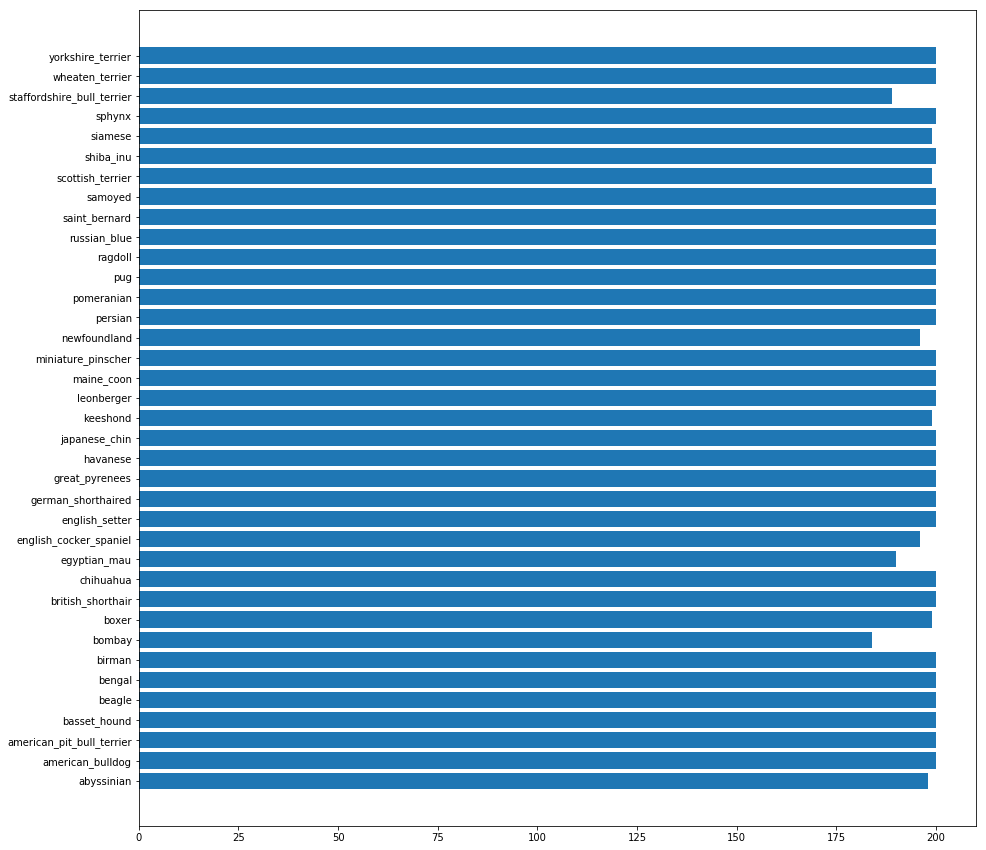

In [11]:
# Checking the distribution of breeds for class balance

fig, ax = plt.subplots(figsize=(15,15))
ax.barh(breeds_pt.index, breeds_pt['id'])

In [12]:
zoom = 1.1

In [13]:
# Sets the augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)

In [14]:
data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test', tfms=tfms, bs=bs, suffix='.jpg', val_idxs=val_idxs, )

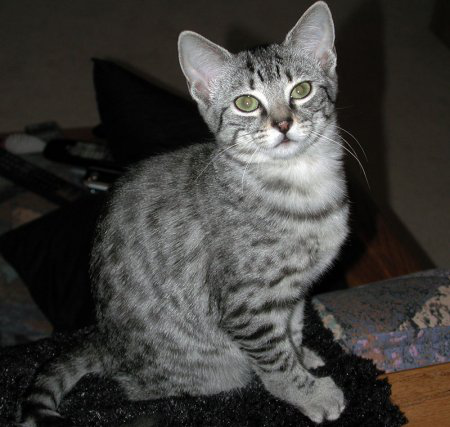

In [15]:
fn = PATH/data.trn_ds.fnames[61]
PIL.Image.open(fn)

In [16]:
len(data.trn_ds), len(data.test_ds), len(data.classes)

(5880, 6849, 37)

### Training the first model

In [17]:
def get_data(sz, bs):
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=zoom)
    data = ImageClassifierData.from_csv(PATH, 'train', labels_csv, test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data

In [18]:
data = get_data(sz, bs)

In [19]:
learn = ConvLearner.pretrained(arch, data, ps=0.6, precompute=True)

In [20]:
learn.lr_find()

 88%|████████▊ | 81/92 [00:00<00:00, 126.04it/s, loss=2.15]


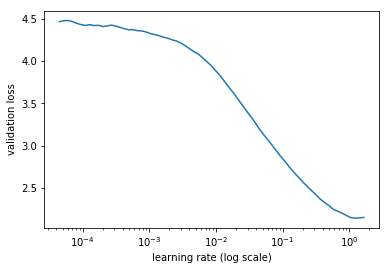

In [21]:
learn.sched.plot()

In [22]:
lr = 1e-2

In [23]:
learn.fit(lr, 12)

epoch      trn_loss   val_loss   accuracy                   
    0      0.846445   0.25316    0.932607  
    1      0.447422   0.193698   0.942818                   
    2      0.311139   0.174991   0.942818                   
    3      0.261989   0.165368   0.940776                   
    4      0.229561   0.160105   0.948945                   
    5      0.198111   0.156191   0.945541                   
    6      0.193338   0.153526   0.946903                   
    7      0.178181   0.146686   0.946903                   
    8      0.169184   0.141785   0.950987                   
    9      0.150326   0.145289   0.946222                   
    10     0.146888   0.142488   0.949626                   
    11     0.13522    0.141904   0.948945                   



[array([ 0.1419]), 0.94894486040871029]

In [24]:
# Turning precompute off allows data augmentation
learn.precompute = False

In [25]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.176056   0.141921   0.949626  
    1      0.183563   0.14224    0.950987                  
    2      0.196277   0.136347   0.95371                   
    3      0.180706   0.137413   0.957114                  
    4      0.177981   0.143144   0.950306                  



[array([ 0.14314]), 0.95030633079672933]

### Changing the size of the images to prevent overfitting

In [26]:
learn.set_data(get_data(299, bs))

In [27]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2, )

epoch      trn_loss   val_loss   accuracy                  
    0      0.17398    0.13607    0.952349  
    1      0.16868    0.135556   0.955071                  
    2      0.16331    0.13687    0.954391                  
    3      0.164537   0.131652   0.957114                  
    4      0.16466    0.139098   0.955071                  
    5      0.143417   0.135887   0.955752                  
    6      0.146132   0.134883   0.955071                  
    7      0.152686   0.13673    0.953029                  
    8      0.1544     0.136621   0.952349                  
    9      0.148657   0.133232   0.954391                  
    10     0.148688   0.129846   0.957114                  
    11     0.146083   0.132605   0.955752                  
    12     0.130304   0.13125    0.955071                  
    13     0.125449   0.130465   0.957114                  
    14     0.137031   0.128965   0.958475                  



[array([ 0.12897]), 0.95847515231334413]

### Fine tuning the frozen layers

In [28]:
# Doesn't seem to make an improvement for this dataset
# bs = 8
# learn.set_data(get_data(299, bs))

In [29]:
# learn.unfreeze()

In [30]:
# lr = np.array([1e-4, 1e-3, 1e-2])

In [31]:
# learn.fit(lr, 2, cycle_len=1, cycle_mult=2, )

### Performing TTA

In [32]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.96051735874744726, 0.11457369422685999)

### Confusion Matrix

In [33]:
preds = np.argmax(probs, axis=1)
probs = np.exp(log_preds)

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[42  0  0 ...,  0  0  0]
 [ 0 26  0 ...,  1  0  0]
 [ 0  4 24 ...,  3  0  0]
 ..., 
 [ 0  3  3 ..., 41  0  0]
 [ 0  0  0 ...,  0 43  0]
 [ 0  0  0 ...,  0  0 39]]


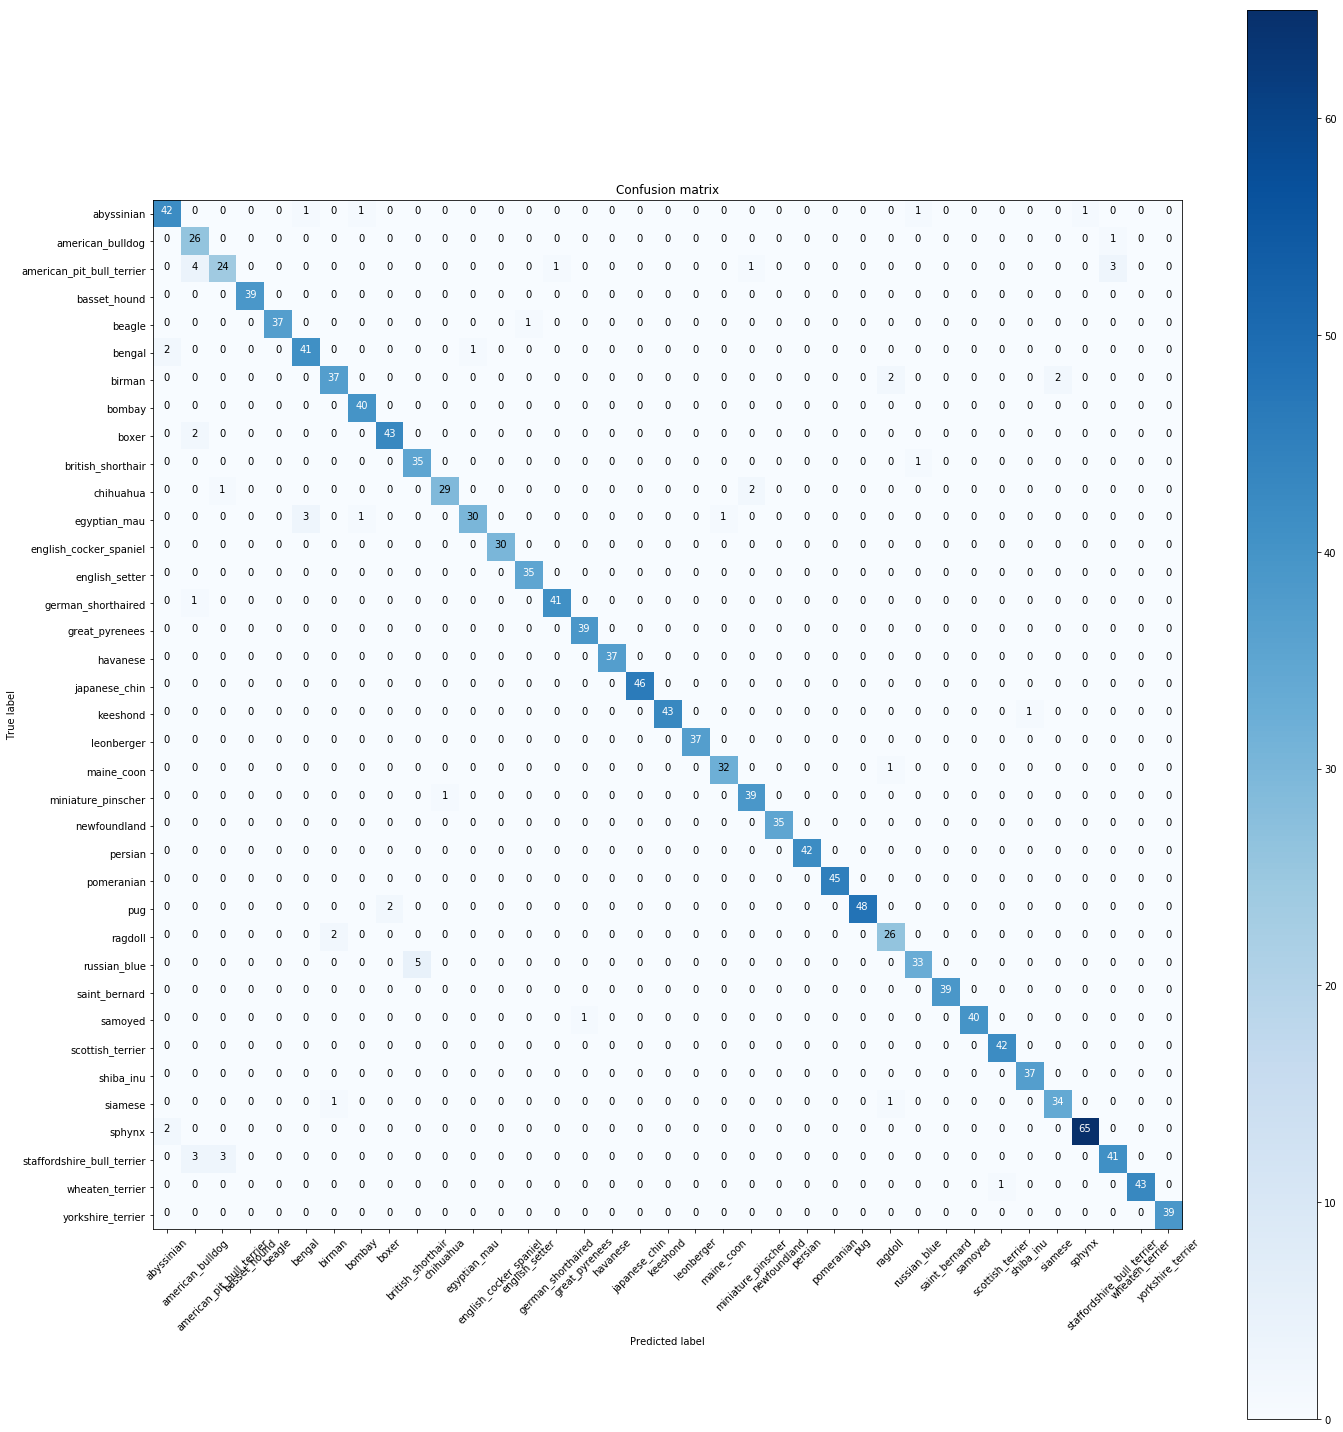

In [35]:
plot_confusion_matrix(cm, data.classes, figsize=(20,20))

### Submission

In [36]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [37]:
# Creates the dataframe with the classes as the column names
submit_df = pd.DataFrame(probs)
submit_df.columns = data.classes

In [38]:
# Inserts a column called 'id' of the picutre ids into the first column of the df
fnames = [names[5:-4] for names in data.test_ds.fnames]
submit_df.insert(0, 'id', fnames)

In [39]:
submit_df.head()

,id,abyssinian,american_bulldog,american_pit_bull_terrier,basset_hound,beagle,bengal,birman,bombay,boxer,...,russian_blue,saint_bernard,samoyed,scottish_terrier,shiba_inu,siamese,sphynx,staffordshire_bull_terrier,wheaten_terrier,yorkshire_terrier
0,bd848ac3c41863b4a393914068fdf3f6,4.032912e-08,8.732479e-04,9.910342e-01,2.964132e-07,3.658364e-07,1.446983e-07,7.153685e-08,4.425624e-08,1.392381e-05,...,2.576848e-05,2.012523e-06,2.580553e-07,6.175226e-07,2.085185e-07,6.118845e-08,5.653593e-07,8.015523e-03,3.735071e-07,1.291738e-06
1,a44f09ed06a79d5cf8372e436e27456a,1.134841e-05,7.532234e-09,9.197661e-07,9.486297e-08,5.761112e-07,4.419343e-06,1.836066e-08,9.997728e-01,1.522882e-07,...,1.096815e-04,9.622054e-09,4.002608e-08,3.287412e-07,1.424977e-07,3.322856e-05,2.227493e-06,1.048710e-06,4.057529e-08,3.042474e-08
2,dfdae801a41553251863569ab00dc403,5.539502e-03,9.502285e-06,8.470574e-04,5.402918e-06,2.365357e-05,3.536194e-05,2.270147e-04,1.734014e-01,8.493678e-05,...,2.733499e-02,7.261745e-07,7.244722e-06,1.663867e-05,4.752808e-04,7.735389e-01,6.046307e-05,2.725086e-04,5.816953e-05,1.063159e-05
3,b3cf9bbe10527c7be747bde3c14a548e,4.691510e-03,1.100947e-07,3.516437e-07,3.003244e-07,2.315375e-07,4.232283e-03,2.066494e-08,6.514346e-06,7.837021e-08,...,9.853992e-03,7.666623e-08,2.050141e-07,1.912666e-07,2.702189e-06,6.539402e-07,4.377655e-05,1.347119e-07,3.370378e-07,2.579924e-07
4,8bf3bb9b54053772254e8d3801bc7e61,3.808716e-09,4.832227e-05,9.913617e-01,3.584780e-08,4.844804e-08,8.126527e-09,3.597982e-09,3.585885e-09,9.041765e-07,...,2.910627e-07,3.920193e-08,3.498034e-08,1.687432e-08,4.483936e-08,1.553325e-08,8.024971e-08,8.586452e-03,1.865037e-08,1.192625e-07


In [40]:
submit_df.to_csv('subm', index=False)